In [2]:
import pickle
import pandas as pd
import os
import yfinance as yf
from utils.plot_decision_trees import plot_tree


from utils.pre_process_data import get_data
from math import ceil
from utils.units import Volume, Dollar
from deap import gp, creator, base, tools
from deap.gp import Terminal
from operator import or_, and_, gt
from fitness_functions import *
from utils.plot_decision_trees import plot_tree
from utils.save_info import save_results
from genetic_functions.cx_functions import cxSubTree
from genetic_functions.mut_functions import mutation_half, mutBranch
from genetic_functions.genetic_program import GPAlgo
import matplotlib.pyplot as plt
import pendulum


In [50]:
eth_ts = get_data(
        ticker = "ETH-USD", 
        start='2016-01-01', 
        end='2024-06-30',
        ma_lags = 50,
        lag_lags = 50,
        pers_col_num = 10
    )

sol_ts = get_data(
        ticker = "SOL-USD", 
        start='2016-01-01', 
        end='2024-06-30',
        ma_lags = 50,
        lag_lags = 50,
        pers_col_num = 10
    )

c:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\utils\pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
c:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\utils\pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
c:\Users\khann\Documents\Data Science and Financial Technology\Final p

In [4]:
df = get_data()
df_train= df.iloc[ : ceil(len(df)*0.7)]
df_test= df.iloc[ceil(len(df)*0.7) : ]

arg_names = list(df_train.columns)
vol_args = [arg for arg in arg_names if "volume" in arg.lower()]
dol_args = [arg for arg in arg_names if "volume" not in arg.lower()]


pset = gp.PrimitiveSetTyped("main",[Volume]*len(vol_args) + [Dollar]*len(dol_args),bool)
        #Rename the arguments:
arg_vol_mapping = {f"ARG{ind}": val for ind,val in enumerate(vol_args)}
pset.renameArguments(**arg_vol_mapping)
arg_dol_mapping = {f"ARG{len(vol_args)+ind}": val for ind,val in enumerate(dol_args)}
pset.renameArguments(**arg_dol_mapping)
#Check that all arguments were renamed:
unnamed_args=[i for i in pset.arguments if "ARG" in i]
if  unnamed_args:
    print(f"Some arguments were not renamed: {unnamed_args}")
pset.addPrimitive(gt, [Dollar,Dollar],bool)
pset.addPrimitive(lambda x:x ,[Dollar],Dollar, name="dollar placeholder")

pset.addPrimitive(gt, [Volume,Volume],bool)
pset.addPrimitive(lambda x:x ,[Volume],Volume, name="volume placeholder")


#Boolean operators:
pset.addPrimitive(and_, [bool,bool],bool)
pset.addPrimitive(or_,[bool,bool],bool)

for v_arg in vol_args:
        pset.addTerminal(v_arg,Volume)
for d_arg in dol_args:
        pset.addTerminal(d_arg,Dollar)

# --- Remove all the ARG terminals ---
pset.terminals[Volume] = [i for i in pset.terminals[Volume] if "ARG" not in i.name]
pset.terminals[Dollar] = [i for i in pset.terminals[Dollar] if "ARG" not in i.name]

def generate(pset):
    run=True
    while run:
        try:
            expr = toolbox.individual()            
            #Remove all the Lambda functions:
            expr=  list(filter(lambda x: x.name!="dollar placeholder", expr))
            expr=  list(filter(lambda x: x.name!="volume placeholder", expr))
            if len(expr)>3:
                run=False
        except IndexError:
            continue
    # return gp.PrimitiveTree(expr)
    return creator.Individual(expr)

# --- GP OPERATORS ----

creator.create("fitness", base.Fitness, weights=(1,))
creator.create("Individual", gp.PrimitiveTree, fitness= creator.fitness)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("custom_individual",generate, pset)
toolbox.register("population", tools.initRepeat, list, toolbox.custom_individual)
toolbox.register("evaluate", fitness_function, df=df_train, pset=pset)

toolbox.register("mate",       cxSubTree)
toolbox.register("select",     tools.selRanked) 
toolbox.register("mutate",     mutation_half, pset=pset)

hof   = tools.HallOfFame(maxsize=50)

#STATS:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0) 
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

c:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\utils\pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
c:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\utils\pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
c:\Users\khann\Documents\Data Science and Financial Technology\Final p

In [7]:
run_list = os.listdir("results_run2_gen3")

In [32]:
best_sol_pop = []
base_dir = r"C:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies"
for dir in run_list:
    if os.path.isdir(rf"{base_dir}\results_run2_gen3\{dir}") and "run" in dir:
        with open(rf"{base_dir}\results_run2_gen3\{dir}\population.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            try:
                hof = pickle.load(file)
                for i in range(len(hof)):
                    best_sol_pop.append(hof[i])
            except:
                print(dir," File not found.")

In [33]:
# with open(r"C:\Users\khann\Documents\Data Science and Financial Technology\Final project\GP_trading_strategies\results_run2_gen3\start_pop.pkl", 'wb') as file:
#     # Serialize the object and write it to the file
#     pickle.dump(best_sol_pop, file)

In [34]:
len(best_sol_pop)

20

In [43]:
best_sol_pop

[[<deap.gp.Primitive at 0x145be68e840>,

In [35]:
best_sol_pop.sort(key = lambda x : x.fitness.values, reverse=True)
print(len(best_sol_pop))
[i.fitness.values for i in best_sol_pop][:5]

20


[(285448.5419218587,),
 (285166.21681575314,),
 (284104.4964312036,),
 (282443.7455561634,),
 (274559.1472519696,)]

In [44]:
per_list = []
for k in best_sol_pop:
    per = [i.split("_")[-1] for i in str(k).split("'") if "percentage" in i]
    if per:
        per_list.append(per)
print(set([i[0] for i in per_list]))

{'57', '60', '11', '37'}


In [45]:

# with open(rf"\home\khann\masters\results\run2_2024-08-09_09-20\logbook.pkl", 'rb') as file:
# # Serialize the object and write it to the file
#     logbook = pickle.load(file)

# with open(rf"\home\khann\masters\results\run2_2024-08-09_09-20\hof.pkl", 'rb') as file:
# # Serialize the object and write it to the file
#     hof2 = pickle.load(file)

In [46]:
# max_lst = []
# for i in logbook:
#     max_lst.append(i['max'])
# x=range(0,len(max_lst))

In [47]:
bs = best_sol_pop
lst_bsp_test = []
lst_bsp_train = []

for i in bs:
    lst_bsp_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])
    lst_bsp_train.append(trading_strat(individual = i, df=df_train ,pset=pset)[:2])
    

TypeError: 'NoneType' object is not subscriptable

Text(0.5, 1.0, 'Fitness values of the strategies.')

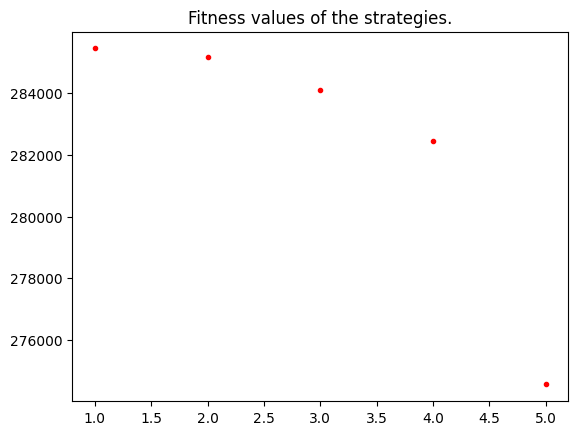

In [ ]:
plt.plot(range(1,len(best_sol_pop)+1),[i.fitness.values for i in best_sol_pop],'r.')
plt.title("Fitness values of the strategies.")

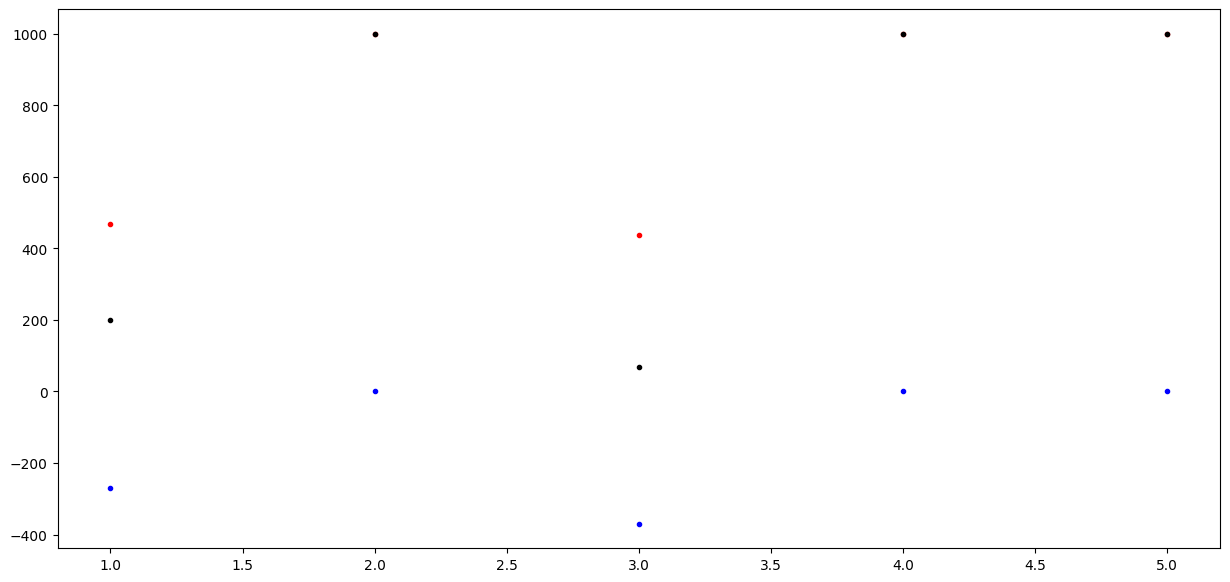

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(bs)+1),[i[0] for i in lst_bsp_test],'r.')
plt.plot(range(1,len(bs)+1),[i[1] for i in lst_bsp_test],'b.')
plt.plot(range(1,len(bs)+1),[i[0]+i[1]  for i in lst_bsp_test],'k.')

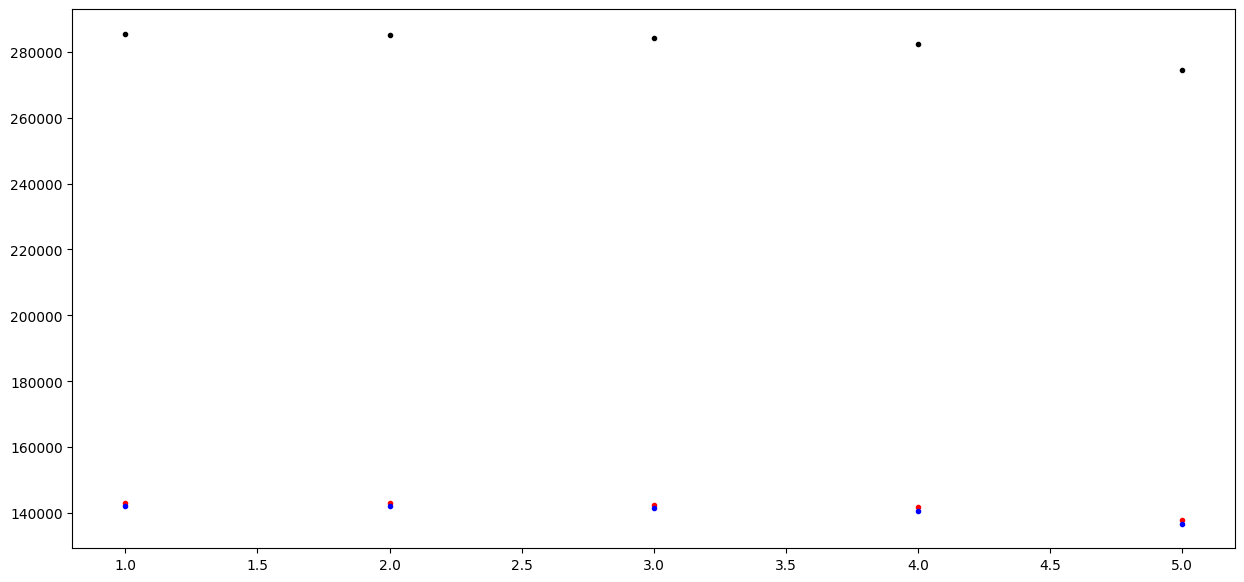

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(bs)+1),[i[0] for i in lst_bsp_train],'r.')
plt.plot(range(1,len(bs)+1),[i[1] for i in lst_bsp_train],'b.')
plt.plot(range(1,len(bs)+1),[i[0]+i[1]  for i in lst_bsp_train],'k.')

In [ ]:
def get_macd_value(df, val = 1000 , tc = 0.01):
    val_ts=[val]
    long=False

    # Add the required columns to the DF:
    df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
    df['ema26'] = df['Open'].ewm(span=26, adjust = False).mean()
    df['macd'] = df['ema12'] - df['ema26']
    df['signal_line'] = df['macd'].ewm(span = 9, adjust=False).mean()
    
    df['macd_above'] = (df['macd'] - df['signal_line'])>0
    df['macd_above_lagged'] = df['macd_above'] .shift(1)

    #Impliment the trading strategy:
    for cnt, row in enumerate(df[['Open','macd_above','macd_above_lagged']].iterrows()):
        if (row[1]['macd_above']==True)  and (row[1]['macd_above_lagged']==False) and long==False:
            shares = ((1-tc)*val)/row[1]['Open']
            long=True
        elif (row[1]['macd_above']==False)  and (row[1]['macd_above_lagged']==True) and long==True:
            val = (1-tc)*shares*row[1]['Open']
            val_ts.append(val)
            long=False
        if cnt == len(df) and long:
            val = shares*row[1]['Open']
            val_ts.append(val)
    return val, val_ts

macd_test_val, macd_test_val_ts = get_macd_value(df = df_test)
macd_train_val, macd_train_val_ts = get_macd_value(df = df_train)

C:\Users\khann\AppData\Local\Temp\ipykernel_12180\2507065365.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
C:\Users\khann\AppData\Local\Temp\ipykernel_12180\2507065365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
C:\Users\khann\AppData\Local\Temp\ipykernel_12180\2507065365.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [40]:
[i.fitness.values for i in best_sol_pop]

[(285448.5419218587,),
 (285166.21681575314,),
 (284104.4964312036,),
 (282443.7455561634,),
 (274559.1472519696,),
 (272818.62977248966,),
 (21315.891354676623,),
 (14723.592631158948,),
 (9705.530802540638,),
 (1000.0,),
 (671.3337378745631,),
 (403.428919262387,),
 (363.0304537395223,),
 (15.146806870704197,),
 (-5.858866264150905,),
 (-168.7335223950295,),
 (-194.73678645005543,),
 (-245.47941606544225,),
 (-410.2737746789403,),
 (-1322.3640670986588,)]

In [42]:
tc = 0.01
#Test data
test_df = pd.DataFrame(columns=["macd","bah","sv"])
for ind,bs in enumerate(best_sol_pop):
    test_results = {
        "macd": macd_test_val,
        "bah":(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2,
        "sv":trading_strat(individual = bs, df=df_test,pset=pset)[0]
    }
    test_df.loc[ind] = test_results

TypeError: 'NoneType' object is not subscriptable

<Axes: title={'center': 'Performance of the trading strategies on the test dataset.'}, xlabel='Stratgy number', ylabel='Final portfolio value'>

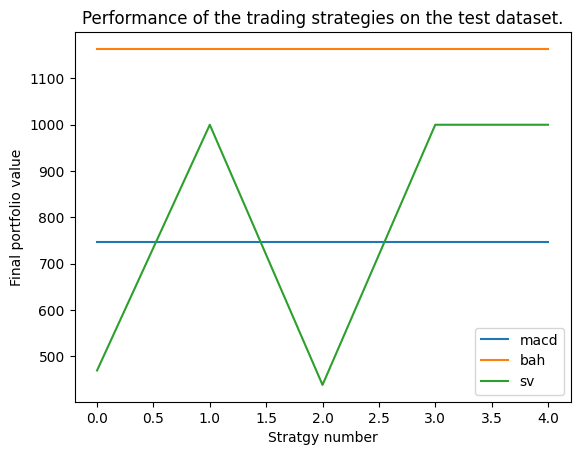

In [ ]:
test_df.plot(title = "Performance of the trading strategies on the test dataset.",xlabel = "Stratgy number", ylabel = "Final portfolio value")

<Axes: title={'center': 'Performance of the trading strategies on the testing dataset.'}, xlabel='Stratgy number', ylabel='Final portfolio value'>

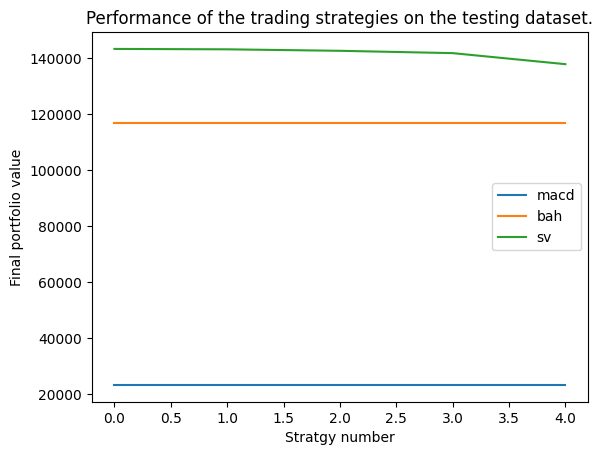

In [ ]:
tc = 0.01
#Train data
train_df = pd.DataFrame(columns=["macd","bah","sv"])
for ind,bs in enumerate(best_sol_pop):
    train_results = {
        "macd": macd_train_val,
        "bah":(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2,
        "sv":trading_strat(individual = bs, df=df_train,pset=pset)[0]
    }
    train_df.loc[ind] = train_results
train_df.plot(title = "Performance of the trading strategies on the testing dataset.",xlabel = "Stratgy number", ylabel = "Final portfolio value")

In [25]:
for i in range(len(best_sol_pop)):
    print(len(best_sol_pop[i]))

27
7
11
19
7


In [48]:
for i in [1,2,3]:
    print(trading_strat(individual = best_sol_pop[i], df=df_train,pset=pset))

(143083.10840787657, 142083.10840787657, [1000, 143083.10840787657])
(142552.2482156018, 141552.2482156018, [1000, 142552.2482156018])
(141721.8727780817, 140721.8727780817, [1000, 141721.8727780817])


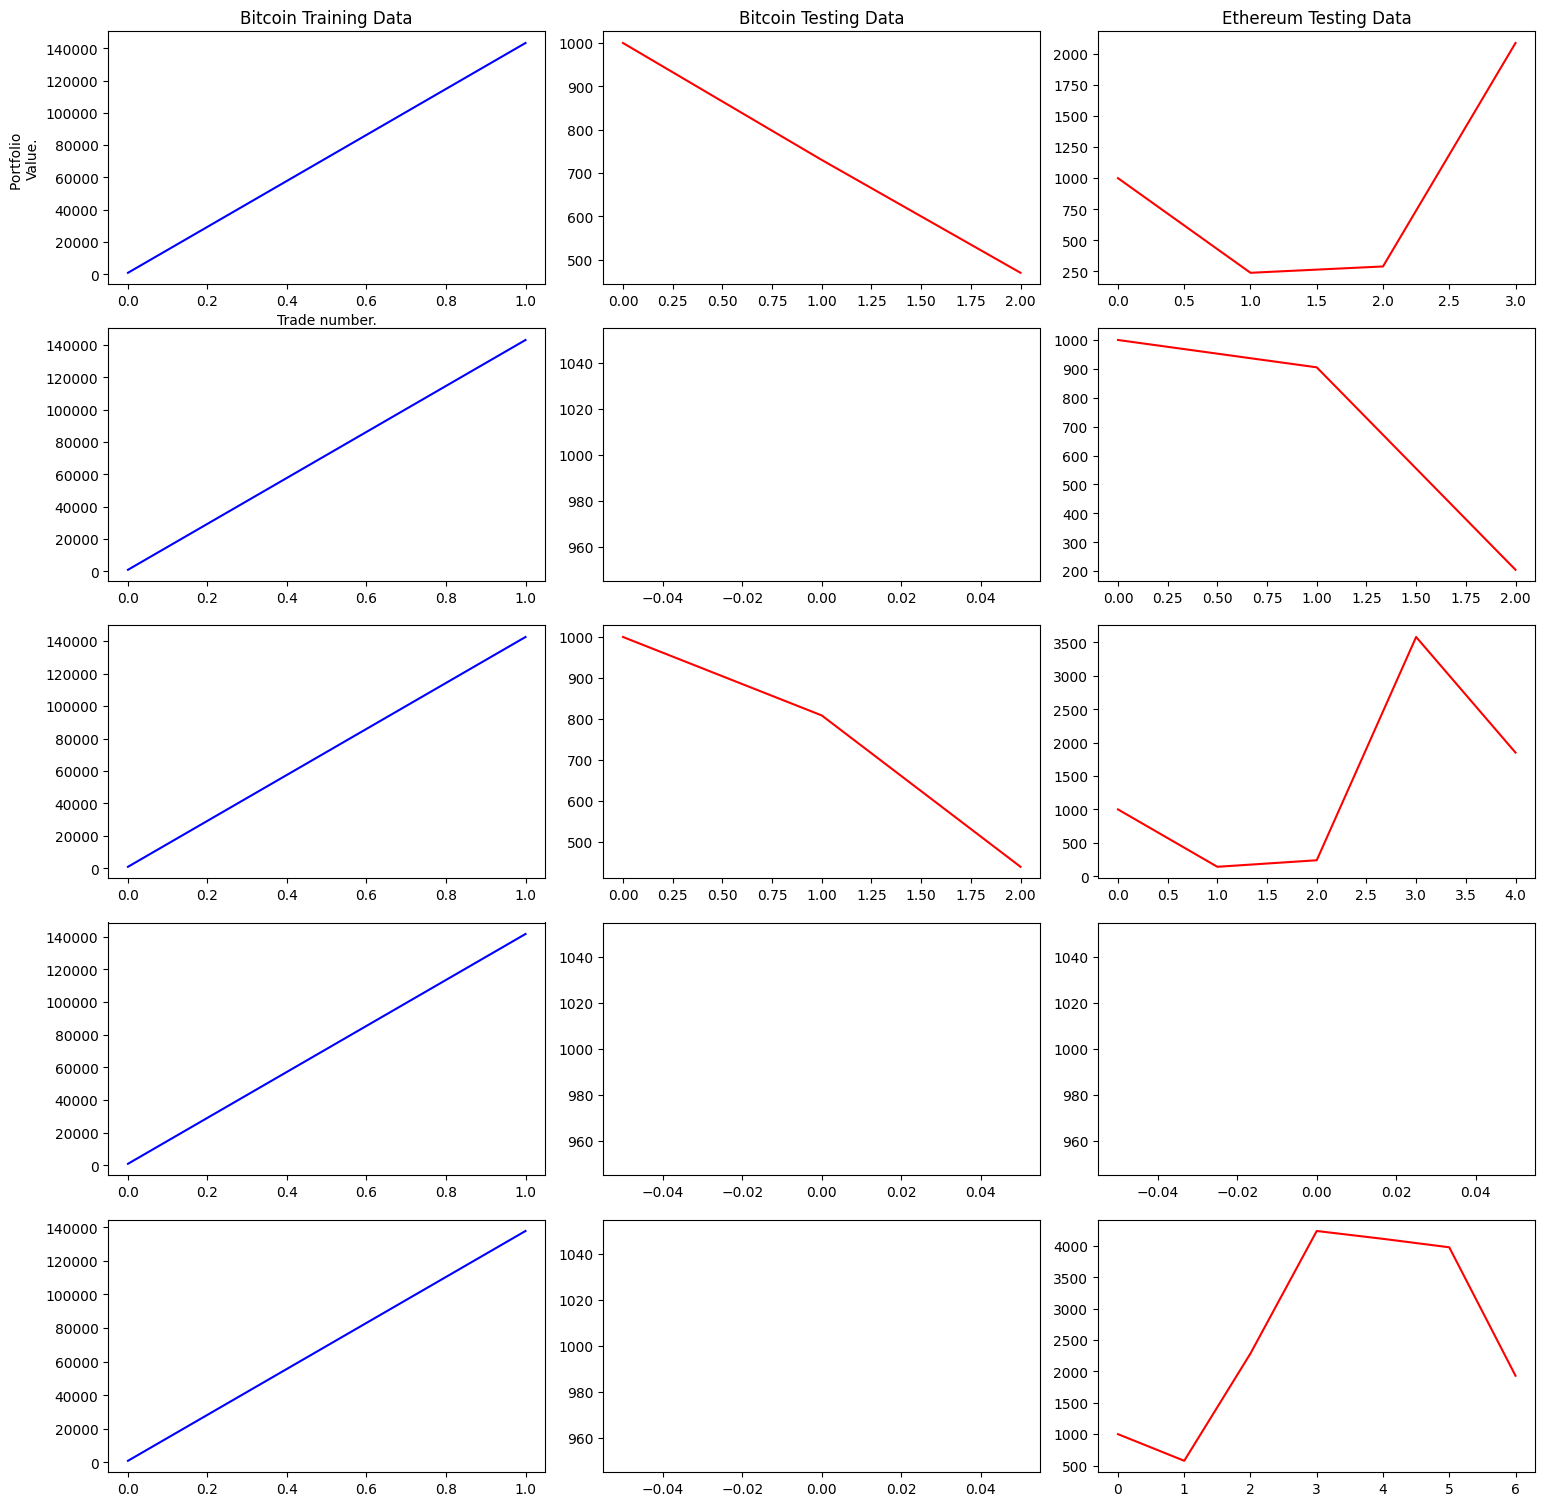

In [49]:
fig, ax = plt.subplots(ncols = 3, nrows = 5, figsize = (15,15))
fig.tight_layout()
ax[0,0].title.set_text("Bitcoin Training Data")
ax[0,0].set_ylabel("Portfolio \nValue.")
ax[0,0].set_xlabel("Trade number.")
ax[0,1].title.set_text("Bitcoin Testing Data")
ax[0,2].title.set_text("Ethereum Testing Data")

for ind in range(5):
    train_ts = trading_strat(individual = best_sol_pop[ind], df=df_train,pset=pset)[2]
    test_ts = trading_strat(individual = best_sol_pop[ind], df=df_test,pset=pset)[2]
    eth_trade_ts = trading_strat(individual = best_sol_pop[ind], df=eth_ts,pset=pset)[2]

    ax[ind,0].plot(range(len(train_ts)),train_ts,color='b')
    ax[ind,1].plot(range(len(test_ts)),test_ts,color='r')
    ax[ind,2].plot(range(len(eth_trade_ts)),eth_trade_ts, color='r')

C:\Users\khann\AppData\Local\Temp\ipykernel_12180\2507065365.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ema12'] = df['Open'].ewm(span=12, adjust = False).mean()
C:\Users\khann\AppData\Local\Temp\ipykernel_12180\2507065365.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ema26'] = df['Open'].ewm(span=26, adjust = False).mean()
C:\Users\khann\AppData\Local\Temp\ipykernel_12180\2507065365.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

<Axes: >

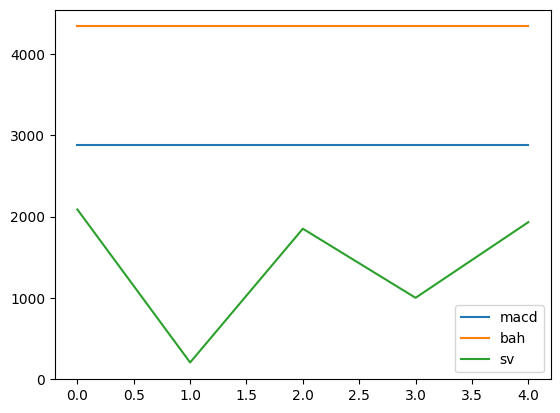

In [29]:
tc = 0.01
macd_eth_val, macd_eth_val_ts = get_macd_value(df = eth_ts)

#ETH data
eth_df = pd.DataFrame(columns=["macd","bah","sv"])
for ind,bs in enumerate(best_sol_pop):
    train_results = {
        "macd": macd_eth_val,
        "bah":(1000/eth_ts.iloc[0]['Open'])*eth_ts.iloc[-1]['Open']*(1-tc)**2,
        "sv":trading_strat(individual = bs, df=eth_ts,pset=pset)[0]
    }
    eth_df.loc[ind] = train_results
eth_df.plot()

In [31]:
best_solution = best_sol_pop[0]
tc = 0.01
print("TEST")
print("MACD: ", macd_test_val)
print("Buy and hold:",(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(df_test))
print("strat value :",trading_strat(individual = best_solution, df=df_test,pset=pset)[0],'\n')

TEST
MACD:  747.6074778499653
Buy and hold: 1163.7100970760914
mtv         : 177218.81839494675
strat value : 469.49078453147257 



In [ ]:
tc = 0.01
print("TRAIN")
print("MACD: ", macd_train_val)
print("Buy and hold:",(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(df_train))
print("strat value :",trading_strat(individual = best_solution, df=df_train,pset=pset)[0],'\n')

TRAIN
MACD:  23212.344970184193
Buy and hold: 116918.97703677377
mtv         : 1950319080593.2593
strat value : 135605.57949999644 



In [ ]:
print("TRAIN")
print("MACD: ", macd_train_val)
print("Buy and hold:",(1000/eth_ts.iloc[0]['Open'])*eth_ts.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(eth_ts))
print("strat value :",trading_strat(individual = best_solution, df=eth_ts,pset=pset)[0],'\n')

TRAIN
MACD:  23212.344970184193
Buy and hold: 4338.1248657593005
mtv         : 625432336014882.5
strat value : 3912.5002669315186 



In [ ]:
# plot_tree(best_sol_pop[8], name="bs_dt8")
from fitness_functions import trading_strat

In [ ]:
val, mdd, ts_val, trade_rows = trading_strat(individual = best_sol_pop[8], df=eth_ts,pset=pset, ret_trade_row=True)
# plt.plot(range(len(bs8)),bs8)
# plt.plot([0,3],df)

In [ ]:
eth_val_ts = []
for i in trade_rows:
    eth_val_ts.append(eth_ts.loc[i[0]]['Open'])
eth_val_ts

[np.float64(137.62745666503906),
 np.float64(2508.544921875),
 np.float64(3401.526123046875)]

In [ ]:
# buy_and_hold:
def buy_and_hold(df,strat):
    val, mdd, ts_val, trade_rows = trading_strat(individual =strat, df=df,pset=pset, ret_trade_row=True)
    bh_val_ts = [1000]
    shares = 1000/df.iloc[0]['Open']
    for i in trade_rows:
        bh_val_ts.append(shares*df.loc[i[0]]['Open']*(1-tc)**2)
    bh_val_ts.append(shares*df.iloc[-1]['Open']*(1-tc)**2)
    return bh_val_ts

eth_bh_ts = buy_and_hold(df=eth_ts ,strat = best_sol_pop[8])

In [ ]:
print("Buy and hold:",(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2)


Buy and hold: 116918.97703677377


In [ ]:
with open(rf"\home\khann\masters\results_run2\run_2024-08-10_02-20\hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            hof = pickle.load(file)

In [ ]:
lst_hof_test = []
for i in hof.items:
    lst_hof_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

lst_hof_train = []
for i in hof.items:
    lst_hof_train.append(trading_strat(individual = i, df=df_train,pset=pset)[:2])

In [ ]:
lst_hof_test

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof)+1),[i[1] for i in lst_hof_test],'b.')
plt.plot(range(1,len(hof)+1),[i[0]+i[1]  for i in lst_hof_test],'k.')

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof)+1),[i[1] for i in lst_hof_train],'b.')
plt.plot(range(1,len(hof)+1),[i[0]+i[1]  for i in lst_hof_train],'k.')

In [ ]:
[i.fitness.values for i in hof.items]

In [ ]:
# import os
# run_list = os.listdir("\home\khann\masters\results_run2_gen2\start_pop")
# run_list

In [ ]:
# cnt=0
# for dir in run_list:
#     if os.path.isdir(rf"\home\khann\masters\results_run2\{dir}"):
#         if cnt == 0:
#             df_tmp = pd.read_csv(rf"\home\khann\masters\results_run2\{dir}\run_info.csv")
#             df_tmp.drop('Unnamed: 0',axis=1, inplace=True)
#         else:
#             d = pd.read_csv(rf"\home\khann\masters\results_run2\{dir}\run_info.csv")
#             d.drop('Unnamed: 0',axis=1, inplace=True)
#             df_tmp = pd.concat([df_tmp, d], ignore_index=True, sort=False)
#         cnt+=1